# Introduction
This notebook is an extension of the previous one, also categorizing Fashion_MNIST but now using more advanced techniques and network architectures. As before, it is a multiclass, single-label classification problem. We'll start by importing everything we'll need later on and loading our data.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__,' ', keras.__version__)
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

dataset = tf.keras.datasets.fashion_mnist
models = tf.keras.models
layers = tf.keras.layers
optimizers = tf.keras.optimizers

(x_train, y_train), (x_test, y_test) = dataset.load_data()

TensorFlow 2.x selected.
2.1.0-rc1   2.2.4-tf
32768/29515 [=================================] - 0s 0us/step


Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step


## Data Explanation
We're using the preinstalled Keras dataset Fashion_MNIST here. It's structured with 60000 training examples and 10000 testing examples, with 10 distinct types of data, evenly distributed in equal amounts randomly throughout both sets of data. The data classes correspond to 1 of 10 different articles of clothing, indexed as follows:
0.  T-shirt/top
1.	Trouser
2.	Pullover
3.	Dress
4.  Coat
5.  Sandal
6.  Shirt
7.  Sneaker
8.  Bag
9. Ankle boot

In [4]:
print('Training size:', len(x_train))
print('Test size:', len(x_test))
print('Target classes:', max(y_test) + 1)

Training size: 60000
Test size: 10000
Target classes: 10


The examples are by default a matrix of integers, 0 to 255, symbolizing a 28 x 28 grayscale picture of the article of clothing in question. This random image, for example, is a coat

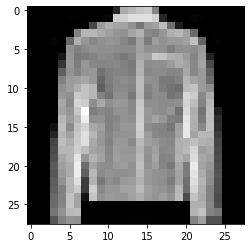

In [5]:
np.random.seed(628)
val = np.random.randint(0, 70000)
plt.imshow(x_train[val], cmap='gray', vmin = 0, vmax = 255)

and the same target in the training data is 4, which represents a coat in the aforementioned key.

In [6]:
print('Target:',y_train[val])

Target: 4


Therefore our goal will be to create a network which classifies pictures of articles of clothing correctly.

# Measure of Success
We will choose accuracy as our measure of success. The more examples the model correctly identifies, the better the model is.

# Evaluation Protocol
For our validation method, we have a choice between hold-out validation and k-fold validation. The latter is more rigorous, but the former is much faster. Since this dataset was created, not just collected, we know that it is of the highest quality: large enough, evenly distributed, and so on. In other words, the problems k-fold validation usually solves aren't present in this dataset, so it's likely fine to use hold-out. We'll hold out 10% of the dataset, both because the dataset is very large and can support this amount and because the previous model used that amount.

# Statistical Power
Previously, we used randomness as the baseline for our model. That is, if the model could predict which of the 10 classes the examples belonged to at least 10% of the time, we considered it good enough to continue. This time, we'll use our prior model as the baseline, as if the model can't beat that, there's no point in using any of the more advanced techniques.

To do this, we'll have to shape our data differently for the baseline and final models. Our first model used multiple densely connected layers, so its inputs will need to be reshaped from 28 x 28 arrays to 1 x 784 arrays. The pixel at location (i, j) will then correspond to the input neuron at index 28 \* i + j. We'll also regularize the input values to be floats between 0 and 1 instead of integers between 0 and 255.

In [7]:
print('Input shape:', x_train.shape)
print('Input value:', x_train[0][15][15])

Input shape: (60000, 28, 28)
Input value: 221


In [0]:
baseline_x_train = x_train.reshape((60000, 28 * 28))
baseline_x_train = baseline_x_train.astype('float32') / 255
baseline_x_test = x_test.reshape((10000, 28 * 28))
baseline_x_test = baseline_x_test.astype('float32') / 255

In [9]:
print('Input shape:', baseline_x_train.shape)
print('Input value:', baseline_x_train[0][15 * 28 + 15])

Input shape: (60000, 784)
Input value: 0.8666667


We'll finally encode the output using one-hot encoding. This will be the same as our final model, so we'll use the same variables.

In [10]:
print('Output value:', y_train[0])

Output value: 9


In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
print('Output value:', y_train[0])

Output value: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Baseline
We'll first build our prior model, so we can compare against it.

In [0]:
baseline = tf.keras.models.Sequential()
baseline.add(tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001), input_shape = (28 * 28,)))
baseline.add(tf.keras.layers.Dropout(0.3))
baseline.add(tf.keras.layers.Dense(10, activation = 'softmax'))
baseline.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [15]:
baseline_history = baseline.fit(baseline_x_train, 
                                y_train,
                                epochs = 200,
                                batch_size = 256,
                                validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/200
54000/54000 [==============================] - 3s 55us/sample - loss: 1.4165 - accuracy: 0.6619 - val_loss: 1.0034 - val_accuracy: 0.7823
Epoch 2/200
54000/54000 [==============================] - 1s 15us/sample - loss: 0.9837 - accuracy: 0.7803 - val_loss: 0.8646 - val_accuracy: 0.8187
Epoch 3/200
54000/54000 [==============================] - 1s 15us/sample - loss: 0.8739 - accuracy: 0.8091 - val_loss: 0.8011 - val_accuracy: 0.8287
Epoch 4/200
54000/54000 [==============================] - 1s 15us/sample - loss: 0.8074 - accuracy: 0.8226 - val_loss: 0.7488 - val_accuracy: 0.8375
Epoch 5/200
54000/54000 [==============================] - 1s 15us/sample - loss: 0.7633 - accuracy: 0.8314 - val_loss: 0.7158 - val_accuracy: 0.8420
Epoch 6/200
54000/54000 [==============================] - 1s 15us/sample - loss: 0.7261 - accuracy: 0.8381 - val_loss: 0.6896 - val_accuracy: 0.8407
Epoch 7/200
54000/54000 [==========================

In [16]:
baseline_loss, baseline_accuracy = baseline.evaluate(baseline_x_test, y_test)
print('Test Accuracy:', baseline_accuracy)

10000/10000 [==============================] - 1s 67us/sample - loss: 0.3481 - accuracy: 0.8921
Test Accuracy: 0.8921


Thus the mark to beat with our new techniques is ~89.1% accuracy.

# Beating the Baseline
We first need to reshape our data to match the inputs our convolutional neural network is expecting. We retain the 2D structure of the images and add a third dimension to represent the single color channel used in grayscale images.

In [0]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((10000, 28, 28, 1))
x_test = x_test.astype('float32') / 255

Now we'll construct our model. The simplest one which beats our previous model has 8 filters, each with a local receptive field of 9 pixels. At the end we'll add the required classifier, a simple 10-neuron softmax dense layer. We continue with the default optimizer and chosen metrics.

In [0]:
better_baseline = models.Sequential()
better_baseline.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
better_baseline.add(layers.Flatten())
better_baseline.add(layers.Dense(10, activation='softmax'))
better_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
better_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                54090     
Total params: 54,170
Trainable params: 54,170
Non-trainable params: 0
_________________________________________________________________


We fit the data to the model, measuring our accuracy on the validation data to determine if it has statistical power.

In [20]:
better_baseline_history = better_baseline.fit(x_train, 
                                              y_train, 
                                              epochs = 25, 
                                              batch_size = 128, 
                                              validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 7s 122us/sample - loss: 0.5370 - accuracy: 0.8128 - val_loss: 0.4008 - val_accuracy: 0.8610
Epoch 2/25
54000/54000 [==============================] - 2s 32us/sample - loss: 0.3793 - accuracy: 0.8680 - val_loss: 0.3631 - val_accuracy: 0.8685
Epoch 3/25
54000/54000 [==============================] - 2s 31us/sample - loss: 0.3367 - accuracy: 0.8816 - val_loss: 0.3323 - val_accuracy: 0.8830
Epoch 4/25
54000/54000 [==============================] - 2s 32us/sample - loss: 0.3109 - accuracy: 0.8906 - val_loss: 0.3192 - val_accuracy: 0.8873
Epoch 5/25
54000/54000 [==============================] - 2s 32us/sample - loss: 0.2936 - accuracy: 0.8967 - val_loss: 0.3101 - val_accuracy: 0.8888
Epoch 6/25
54000/54000 [==============================] - 2s 31us/sample - loss: 0.2787 - accuracy: 0.9015 - val_loss: 0.3021 - val_accuracy: 0.8920
Epoch 7/25
54000/54000 [==============================] 

<function matplotlib.pyplot.show>

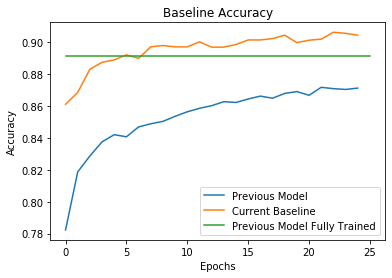

In [21]:
plt.plot(baseline_history.history['val_accuracy'][0:25])
plt.plot(better_baseline_history.history['val_accuracy'])
plt.plot([0, 25], [0.891, 0.891])
plt.title('Baseline Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Previous Model', 'Current Baseline', 'Previous Model Fully Trained'], loc = 'lower right')
plt.show

There are two important things to note here. First, the baseline model just constructed beats the previous model's validation accuracy immediately, as that model took 200 epochs to train fully. Secondly, the baseline model beats even the fully trained model's test accuracy after only 10 epochs, suggesting it is significantly more efficient than the previous model. We'll continue with convolutional layers, as they appear to work well for this problem.

# Overfitting
We'll now expand the network in order to develop the most efficient architecture. We'll split our development into two sections: first, the convolutional image processing layers; and second, the dense classification layers. We'll show here 5 of the best convolutional architectures attempted, across the spectrum of complexity. For this part, we'll use a stride length of 1, a local receptive field of 3 x 3 neurons, and intermediate MaxPooling layers across 2 x 2 neurons as Chollet recommends. We need a final densely-connected softmax layer to classify the pictures, though for the initial stage of development we'll add no more dense layers beyond this.
1.   1 layer: 64 neurons
2.   2 layers 128 - 512 neurons
3.   2 layers: 64 - 256 neurons
4.   3 layers: 32 - 512 - 512 neurons
5.   3 layers: 64 - 128 - 256 neurons

In [22]:
network64 = models.Sequential()
network64.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64.add(layers.Flatten())
network64.add(layers.Dense(10, activation='softmax'))
network64.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                432650    
Total params: 433,290
Trainable params: 433,290
Non-trainable params: 0
_________________________________________________________________


In [23]:
network128_512 = models.Sequential()
network128_512.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network128_512.add(layers.MaxPooling2D((2, 2)))
network128_512.add(layers.Conv2D(512, (3, 3), activation='relu'))
network128_512.add(layers.Flatten())
network128_512.add(layers.Dense(10, activation='softmax'))
network128_512.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network128_512.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 512)       590336    
_________________________________________________________________
flatten_2 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                619530    
Total params: 1,211,146
Trainable params: 1,211,146
Non-trainable params: 0
_________________________________________________________________


In [24]:
network64_256 = models.Sequential()
network64_256.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256.add(layers.MaxPooling2D((2, 2)))
network64_256.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_256.add(layers.Flatten())
network64_256.add(layers.Dense(10, activation='softmax'))
network64_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 256)       147712    
_________________________________________________________________
flatten_3 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                309770    
Total params: 458,122
Trainable params: 458,122
Non-trainable params: 0
_________________________________________________________________


In [25]:
network32_512_512 = models.Sequential()
network32_512_512.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network32_512_512.add(layers.MaxPooling2D((2, 2)))
network32_512_512.add(layers.Conv2D(512, (3, 3), activation='relu'))
network32_512_512.add(layers.MaxPooling2D((2, 2)))
network32_512_512.add(layers.Conv2D(512, (3, 3), activation='relu'))
network32_512_512.add(layers.Flatten())
network32_512_512.add(layers.Dense(10, activation='softmax'))
network32_512_512.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network32_512_512.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 512)       147968    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 512)         2359808   
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [26]:
network64_128_256 = models.Sequential()
network64_128_256.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_128_256.add(layers.MaxPooling2D((2, 2)))
network64_128_256.add(layers.Conv2D(128, (3, 3), activation='relu'))
network64_128_256.add(layers.MaxPooling2D((2, 2)))
network64_128_256.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_128_256.add(layers.Flatten())
network64_128_256.add(layers.Dense(10, activation='softmax'))
network64_128_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_128_256.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 256)         295168    
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [27]:
network64_history = network64.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 4s 65us/sample - loss: 0.4629 - accuracy: 0.8372 - val_loss: 0.3379 - val_accuracy: 0.8777
Epoch 2/25
54000/54000 [==============================] - 3s 56us/sample - loss: 0.3060 - accuracy: 0.8918 - val_loss: 0.3203 - val_accuracy: 0.8848
Epoch 3/25
54000/54000 [==============================] - 3s 57us/sample - loss: 0.2682 - accuracy: 0.9044 - val_loss: 0.2964 - val_accuracy: 0.8945
Epoch 4/25
54000/54000 [==============================] - 3s 57us/sample - loss: 0.2434 - accuracy: 0.9132 - val_loss: 0.2877 - val_accuracy: 0.9012
Epoch 5/25
54000/54000 [==============================] - 3s 57us/sample - loss: 0.2254 - accuracy: 0.9205 - val_loss: 0.2926 - val_accuracy: 0.8960
Epoch 6/25
54000/54000 [==============================] - 3s 57us/sample - loss: 0.2101 - accuracy: 0.9265 - val_loss: 0.2820 - val_accuracy: 0.9093
Epoch 7/25
54000/54000 [==============================] -

In [28]:
network128_512_history = network128_512.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 11s 205us/sample - loss: 0.4476 - accuracy: 0.8408 - val_loss: 0.3227 - val_accuracy: 0.8848
Epoch 2/25
54000/54000 [==============================] - 10s 190us/sample - loss: 0.2698 - accuracy: 0.9029 - val_loss: 0.2573 - val_accuracy: 0.9087
Epoch 3/25
54000/54000 [==============================] - 10s 190us/sample - loss: 0.2259 - accuracy: 0.9177 - val_loss: 0.2534 - val_accuracy: 0.9057
Epoch 4/25
54000/54000 [==============================] - 10s 188us/sample - loss: 0.1945 - accuracy: 0.9286 - val_loss: 0.2383 - val_accuracy: 0.9147
Epoch 5/25
54000/54000 [==============================] - 10s 190us/sample - loss: 0.1704 - accuracy: 0.9387 - val_loss: 0.2422 - val_accuracy: 0.9163
Epoch 6/25
54000/54000 [==============================] - 10s 190us/sample - loss: 0.1511 - accuracy: 0.9460 - val_loss: 0.2430 - val_accuracy: 0.9208
Epoch 7/25
54000/54000 [=====================

In [29]:
network64_256_history = network64_256.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 6s 110us/sample - loss: 0.4494 - accuracy: 0.8388 - val_loss: 0.3290 - val_accuracy: 0.8768
Epoch 2/25
54000/54000 [==============================] - 5s 100us/sample - loss: 0.2831 - accuracy: 0.8979 - val_loss: 0.2750 - val_accuracy: 0.8978
Epoch 3/25
54000/54000 [==============================] - 5s 101us/sample - loss: 0.2368 - accuracy: 0.9151 - val_loss: 0.2622 - val_accuracy: 0.9030
Epoch 4/25
54000/54000 [==============================] - 5s 101us/sample - loss: 0.2057 - accuracy: 0.9261 - val_loss: 0.2428 - val_accuracy: 0.9125
Epoch 5/25
54000/54000 [==============================] - 5s 99us/sample - loss: 0.1823 - accuracy: 0.9345 - val_loss: 0.2594 - val_accuracy: 0.9078
Epoch 6/25
54000/54000 [==============================] - 6s 102us/sample - loss: 0.1633 - accuracy: 0.9414 - val_loss: 0.2259 - val_accuracy: 0.9237
Epoch 7/25
54000/54000 [============================

In [30]:
network32_512_512_history = network32_512_512.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 11s 202us/sample - loss: 0.4977 - accuracy: 0.8169 - val_loss: 0.3456 - val_accuracy: 0.8712
Epoch 2/25
54000/54000 [==============================] - 10s 182us/sample - loss: 0.2930 - accuracy: 0.8930 - val_loss: 0.2727 - val_accuracy: 0.9018
Epoch 3/25
54000/54000 [==============================] - 10s 181us/sample - loss: 0.2408 - accuracy: 0.9120 - val_loss: 0.2531 - val_accuracy: 0.9070
Epoch 4/25
54000/54000 [==============================] - 10s 181us/sample - loss: 0.2048 - accuracy: 0.9254 - val_loss: 0.2407 - val_accuracy: 0.9118
Epoch 5/25
54000/54000 [==============================] - 10s 182us/sample - loss: 0.1739 - accuracy: 0.9346 - val_loss: 0.2379 - val_accuracy: 0.9123
Epoch 6/25
54000/54000 [==============================] - 10s 181us/sample - loss: 0.1481 - accuracy: 0.9459 - val_loss: 0.2489 - val_accuracy: 0.9125
Epoch 7/25
54000/54000 [=====================

In [31]:
network64_128_256_history = network64_128_256.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 5s 101us/sample - loss: 0.5327 - accuracy: 0.8053 - val_loss: 0.3469 - val_accuracy: 0.8767
Epoch 2/25
54000/54000 [==============================] - 5s 89us/sample - loss: 0.3226 - accuracy: 0.8825 - val_loss: 0.3326 - val_accuracy: 0.8772
Epoch 3/25
54000/54000 [==============================] - 5s 89us/sample - loss: 0.2718 - accuracy: 0.9016 - val_loss: 0.2742 - val_accuracy: 0.9030
Epoch 4/25
54000/54000 [==============================] - 5s 89us/sample - loss: 0.2374 - accuracy: 0.9119 - val_loss: 0.2528 - val_accuracy: 0.9093
Epoch 5/25
54000/54000 [==============================] - 5s 89us/sample - loss: 0.2098 - accuracy: 0.9226 - val_loss: 0.2476 - val_accuracy: 0.9135
Epoch 6/25
54000/54000 [==============================] - 5s 89us/sample - loss: 0.1862 - accuracy: 0.9318 - val_loss: 0.2383 - val_accuracy: 0.9168
Epoch 7/25
54000/54000 [==============================] 

<function matplotlib.pyplot.show>

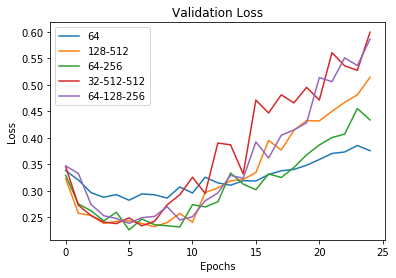

In [32]:
plt.plot(network64_history.history['val_loss'])
plt.plot(network128_512_history.history['val_loss'])
plt.plot(network64_256_history.history['val_loss'])
plt.plot(network32_512_512_history.history['val_loss'])
plt.plot(network64_128_256_history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['64', '128-512', '64-256', '32-512-512', '64-128-256'], loc = 'upper left')
plt.show

In [33]:
val, idx = min((val, idx) for (idx, val) in enumerate(network64_history.history['val_loss']))
print('Minimum loss with 64 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network128_512_history.history['val_loss']))
print('Minimum loss with 128-512 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network64_256_history.history['val_loss']))
print('Minimum loss with 64-256 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network32_512_512_history.history['val_loss']))
print('Minimum loss with 32-512-512 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network64_128_256_history.history['val_loss']))
print('Minimum loss with 64-128-256 nodes:', val, 'at', idx + 1, 'epochs')

Minimum loss with 64 nodes: 0.28201783672968544 at 6 epochs
Minimum loss with 128-512 nodes: 0.23218817500273387 at 8 epochs
Minimum loss with 64-256 nodes: 0.22594582386811574 at 6 epochs
Minimum loss with 32-512-512 nodes: 0.23365396757920584 at 7 epochs
Minimum loss with 64-128-256 nodes: 0.23828383815288542 at 6 epochs


<function matplotlib.pyplot.show>

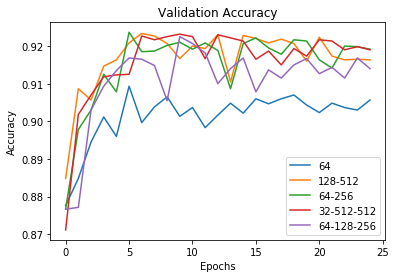

In [34]:
plt.plot(network64_history.history['val_accuracy'])
plt.plot(network128_512_history.history['val_accuracy'])
plt.plot(network64_256_history.history['val_accuracy'])
plt.plot(network32_512_512_history.history['val_accuracy'])
plt.plot(network64_128_256_history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['64', '128-512', '64-256', '32-512-512', '64-128-256'], loc = 'lower right')
plt.show

We can see that the architecture with 64 neurons in the first layer and 256 neurons in the second layer has the lowest minimum loss, the lowest loss each epoch on average , and the highest accuracy each epoch on average. Because of this clear superiority, we'll continue with this layer architecture throughout the remaining trials.

In the second stage of development, we want to find the best classifier composed of densely-connected layers possible. This will be placed atop the previous convolutional layers to create the final architecture. Again, we'll show 5 of the best architectures attempted.
1. 0 (only the final softmax layer)
2. 32
3. 64
4. 128-32
5. 256-128

In [35]:
network64_256_32 = models.Sequential()
network64_256_32.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256_32.add(layers.MaxPooling2D((2, 2)))
network64_256_32.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_256_32.add(layers.Flatten())
network64_256_32.add(layers.Dense(32, activation='relu'))
network64_256_32.add(layers.Dense(10, activation='softmax'))
network64_256_32.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256_32.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
flatten_6 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                991264    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 1,139,946
Trainable params: 1,139,946
Non-trainable params: 0
____________________________________________

In [36]:
network64_256_64 = models.Sequential()
network64_256_64.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256_64.add(layers.MaxPooling2D((2, 2)))
network64_256_64.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_256_64.add(layers.Flatten())
network64_256_64.add(layers.Dense(64, activation='relu'))
network64_256_64.add(layers.Dense(10, activation='softmax'))
network64_256_64.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256_64.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
flatten_7 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1982528   
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 2,131,530
Trainable params: 2,131,530
Non-trainable params: 0
____________________________________________

In [37]:
network64_256_128_32 = models.Sequential()
network64_256_128_32.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256_128_32.add(layers.MaxPooling2D((2, 2)))
network64_256_128_32.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_256_128_32.add(layers.Flatten())
network64_256_128_32.add(layers.Dense(128, activation='relu'))
network64_256_128_32.add(layers.Dense(32, activation='relu'))
network64_256_128_32.add(layers.Dense(10, activation='softmax'))
network64_256_128_32.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256_128_32.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
flatten_8 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3965056   
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

In [38]:
network64_256_256_128 = models.Sequential()
network64_256_256_128.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256_256_128.add(layers.MaxPooling2D((2, 2)))
network64_256_256_128.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_256_256_128.add(layers.Flatten())
network64_256_256_128.add(layers.Dense(256, activation='relu'))
network64_256_256_128.add(layers.Dense(128, activation='relu'))
network64_256_256_128.add(layers.Dense(10, activation='softmax'))
network64_256_256_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256_256_128.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
flatten_9 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               7930112   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 10)              

In [39]:
network64_256_32_history = network64_256_32.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 6s 116us/sample - loss: 0.5000 - accuracy: 0.8237 - val_loss: 0.3177 - val_accuracy: 0.8852
Epoch 2/25
54000/54000 [==============================] - 6s 107us/sample - loss: 0.2855 - accuracy: 0.8976 - val_loss: 0.2738 - val_accuracy: 0.8973
Epoch 3/25
54000/54000 [==============================] - 6s 106us/sample - loss: 0.2317 - accuracy: 0.9156 - val_loss: 0.2408 - val_accuracy: 0.9118
Epoch 4/25
54000/54000 [==============================] - 6s 108us/sample - loss: 0.1960 - accuracy: 0.9287 - val_loss: 0.2376 - val_accuracy: 0.9167
Epoch 5/25
54000/54000 [==============================] - 6s 106us/sample - loss: 0.1668 - accuracy: 0.9389 - val_loss: 0.2194 - val_accuracy: 0.9240
Epoch 6/25
54000/54000 [==============================] - 6s 107us/sample - loss: 0.1438 - accuracy: 0.9477 - val_loss: 0.2252 - val_accuracy: 0.9220
Epoch 7/25
54000/54000 [===========================

In [40]:
network64_256_64_history = network64_256_64.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 7s 125us/sample - loss: 0.4766 - accuracy: 0.8290 - val_loss: 0.3177 - val_accuracy: 0.8848
Epoch 2/25
54000/54000 [==============================] - 6s 118us/sample - loss: 0.2687 - accuracy: 0.9037 - val_loss: 0.2890 - val_accuracy: 0.8968
Epoch 3/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.2153 - accuracy: 0.9222 - val_loss: 0.2434 - val_accuracy: 0.9083
Epoch 4/25
54000/54000 [==============================] - 6s 115us/sample - loss: 0.1780 - accuracy: 0.9348 - val_loss: 0.2631 - val_accuracy: 0.9085
Epoch 5/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.1505 - accuracy: 0.9450 - val_loss: 0.2261 - val_accuracy: 0.9232
Epoch 6/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.1240 - accuracy: 0.9552 - val_loss: 0.2378 - val_accuracy: 0.9200
Epoch 7/25
54000/54000 [===========================

In [41]:
network64_256_128_32_history = network64_256_128_32.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 8s 143us/sample - loss: 0.4971 - accuracy: 0.8205 - val_loss: 0.3097 - val_accuracy: 0.8897
Epoch 2/25
54000/54000 [==============================] - 7s 130us/sample - loss: 0.2782 - accuracy: 0.8986 - val_loss: 0.3058 - val_accuracy: 0.8895
Epoch 3/25
54000/54000 [==============================] - 7s 129us/sample - loss: 0.2206 - accuracy: 0.9193 - val_loss: 0.2336 - val_accuracy: 0.9130
Epoch 4/25
54000/54000 [==============================] - 7s 130us/sample - loss: 0.1797 - accuracy: 0.9347 - val_loss: 0.2341 - val_accuracy: 0.9140
Epoch 5/25
54000/54000 [==============================] - 7s 130us/sample - loss: 0.1491 - accuracy: 0.9448 - val_loss: 0.2428 - val_accuracy: 0.9228
Epoch 6/25
54000/54000 [==============================] - 7s 129us/sample - loss: 0.1237 - accuracy: 0.9533 - val_loss: 0.2582 - val_accuracy: 0.9197
Epoch 7/25
54000/54000 [===========================

In [42]:
network64_256_256_128_history = network64_256_256_128.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 9s 162us/sample - loss: 0.4674 - accuracy: 0.8291 - val_loss: 0.3067 - val_accuracy: 0.8857
Epoch 2/25
54000/54000 [==============================] - 8s 151us/sample - loss: 0.2608 - accuracy: 0.9029 - val_loss: 0.2518 - val_accuracy: 0.9062
Epoch 3/25
54000/54000 [==============================] - 8s 151us/sample - loss: 0.2036 - accuracy: 0.9249 - val_loss: 0.2528 - val_accuracy: 0.9110
Epoch 4/25
54000/54000 [==============================] - 8s 151us/sample - loss: 0.1612 - accuracy: 0.9398 - val_loss: 0.2482 - val_accuracy: 0.9118
Epoch 5/25
54000/54000 [==============================] - 8s 150us/sample - loss: 0.1306 - accuracy: 0.9524 - val_loss: 0.2766 - val_accuracy: 0.9182
Epoch 6/25
54000/54000 [==============================] - 8s 152us/sample - loss: 0.1053 - accuracy: 0.9617 - val_loss: 0.2609 - val_accuracy: 0.9152
Epoch 7/25
54000/54000 [===========================

<function matplotlib.pyplot.show>

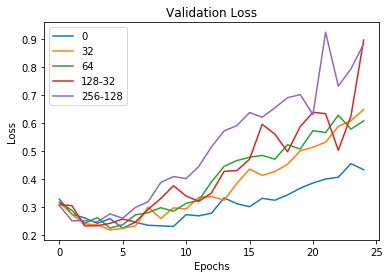

In [43]:
plt.plot(network64_256_history.history['val_loss'])
plt.plot(network64_256_32_history.history['val_loss'])
plt.plot(network64_256_64_history.history['val_loss'])
plt.plot(network64_256_128_32_history.history['val_loss'])
plt.plot(network64_256_256_128_history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['0', '32', '64', '128-32', '256-128'], loc = 'upper left')
plt.show

In [44]:
val, idx = min((val, idx) for (idx, val) in enumerate(network64_256_history.history['val_loss']))
print('Minimum loss with 0 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network64_256_32_history.history['val_loss']))
print('Minimum loss with 32 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network64_256_64_history.history['val_loss']))
print('Minimum loss with 64 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network64_256_128_32_history.history['val_loss']))
print('Minimum loss with 128-32 nodes:', val, 'at', idx + 1, 'epochs')
val, idx = min((val, idx) for (idx, val) in enumerate(network64_256_256_128_history.history['val_loss']))
print('Minimum loss with 256-128 nodes:', val, 'at', idx + 1, 'epochs')

Minimum loss with 0 nodes: 0.22594582386811574 at 6 epochs
Minimum loss with 32 nodes: 0.21935636115074159 at 5 epochs
Minimum loss with 64 nodes: 0.226113809466362 at 5 epochs
Minimum loss with 128-32 nodes: 0.23363850792249044 at 3 epochs
Minimum loss with 256-128 nodes: 0.2481997352441152 at 4 epochs


<function matplotlib.pyplot.show>

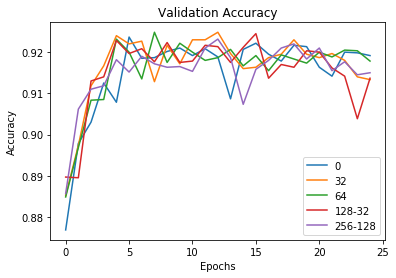

In [45]:
plt.plot(network64_256_history.history['val_accuracy'])
plt.plot(network64_256_32_history.history['val_accuracy'])
plt.plot(network64_256_64_history.history['val_accuracy'])
plt.plot(network64_256_128_32_history.history['val_accuracy'])
plt.plot(network64_256_256_128_history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['0', '32', '64', '128-32', '256-128'], loc = 'lower right')
plt.show

We see that the network without any extra classifier on top has the lowest loss at every epoch; however, its accuracy is also one of the lowest. As this is our desired metric, we'll pick the network with a 64-neuron classifier, as it has the highest accuracy along with the second lowest loss.

## Depthwise Separable Convolutional Layers
We'll try now to use depthwise separable convolutional layers as a drop-in replacement for our previous Conv2D layers. Everything else will be kept the same.

In [46]:
network64_256_64_separable = models.Sequential()
network64_256_64_separable.add(layers.SeparableConv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256_64_separable.add(layers.MaxPooling2D((2, 2)))
network64_256_64_separable.add(layers.SeparableConv2D(256, (3, 3), activation='relu'))
network64_256_64_separable.add(layers.Flatten())
network64_256_64_separable.add(layers.Dense(64, activation='relu'))
network64_256_64_separable.add(layers.Dense(10, activation='softmax'))
network64_256_64_separable.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256_64_separable.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 26, 26, 64)        137       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 11, 11, 256)       17216     
_________________________________________________________________
flatten_10 (Flatten)         (None, 30976)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                1982528   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 2,000,531
Trainable params: 2,000,531
Non-trainable params: 0
___________________________________________

In [47]:
network64_256_64_separable_history = network64_256_64_separable.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 7s 136us/sample - loss: 0.6099 - accuracy: 0.7767 - val_loss: 0.4536 - val_accuracy: 0.8328
Epoch 2/25
54000/54000 [==============================] - 7s 122us/sample - loss: 0.3943 - accuracy: 0.8575 - val_loss: 0.3529 - val_accuracy: 0.8673
Epoch 3/25
54000/54000 [==============================] - 6s 120us/sample - loss: 0.3375 - accuracy: 0.8772 - val_loss: 0.3608 - val_accuracy: 0.8677
Epoch 4/25
54000/54000 [==============================] - 6s 120us/sample - loss: 0.3026 - accuracy: 0.8879 - val_loss: 0.3183 - val_accuracy: 0.8835
Epoch 5/25
54000/54000 [==============================] - 7s 121us/sample - loss: 0.2758 - accuracy: 0.8987 - val_loss: 0.2896 - val_accuracy: 0.8945
Epoch 6/25
54000/54000 [==============================] - 7s 121us/sample - loss: 0.2551 - accuracy: 0.9068 - val_loss: 0.3096 - val_accuracy: 0.8847
Epoch 7/25
54000/54000 [===========================

<function matplotlib.pyplot.show>

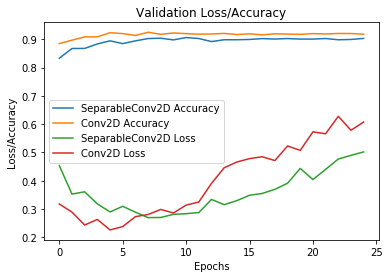

In [48]:
plt.plot(network64_256_64_separable_history.history['val_accuracy'])
plt.plot(network64_256_64_history.history['val_accuracy'])
plt.plot(network64_256_64_separable_history.history['val_loss'])
plt.plot(network64_256_64_history.history['val_loss'])
plt.title('Validation Loss/Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.legend(['SeparableConv2D Accuracy', 'Conv2D Accuracy', 'SeparableConv2D Loss', 'Conv2D Loss'], loc = 'best')
plt.show

As we can see, the loss and accuracy are both worse in the SeparableConv2D layers than in the normal Conv2D layers. This could be because SeparableConv2D's main advantage lies in its ability to work with multiple channels, while Fashion_MNIST has only 1 color channel. Either way, we'll continue using Conv2D.

# Regularization
We now want to regularize the model, to get as close to a perfect network as is possible. To do so, we will adjust the following hyper-parameters:

1. Batch Normalization
1. Batch Size
2. Dropout
3. Weight Regularization
4. Learning Rate

## Batch Normalization
We'll try inserting batch normalization layers after the our convolutional and dense layers, and we'll see if they improve the model.

In [49]:
network64_256_64_batch = models.Sequential()
network64_256_64_batch.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network64_256_64_batch.add(layers.BatchNormalization())
network64_256_64_batch.add(layers.MaxPooling2D((2, 2)))
network64_256_64_batch.add(layers.Conv2D(256, (3, 3), activation='relu'))
network64_256_64_batch.add(layers.BatchNormalization())
network64_256_64_batch.add(layers.Flatten())
network64_256_64_batch.add(layers.Dense(64, activation='relu'))
network64_256_64_batch.add(layers.BatchNormalization())
network64_256_64_batch.add(layers.Dense(10, activation='softmax'))
network64_256_64_batch.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
network64_256_64_batch.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
flatten_11 (Flatten)         (None, 30976)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

In [50]:
network64_256_64_batch_history = network64_256_64_batch.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 9s 161us/sample - loss: 0.3498 - accuracy: 0.8767 - val_loss: 1.4339 - val_accuracy: 0.6447
Epoch 2/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.2087 - accuracy: 0.9254 - val_loss: 0.2181 - val_accuracy: 0.9238
Epoch 3/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.1568 - accuracy: 0.9442 - val_loss: 0.3066 - val_accuracy: 0.9007
Epoch 4/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.1188 - accuracy: 0.9581 - val_loss: 0.2595 - val_accuracy: 0.9093
Epoch 5/25
54000/54000 [==============================] - 8s 143us/sample - loss: 0.0913 - accuracy: 0.9676 - val_loss: 0.2712 - val_accuracy: 0.9215
Epoch 6/25
54000/54000 [==============================] - 8s 143us/sample - loss: 0.0693 - accuracy: 0.9766 - val_loss: 0.2965 - val_accuracy: 0.9217
Epoch 7/25
54000/54000 [===========================

<function matplotlib.pyplot.show>

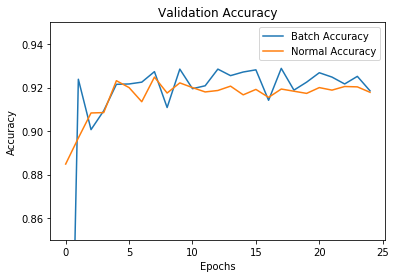

In [51]:
plt.plot(network64_256_64_batch_history.history['val_accuracy'])
plt.plot(network64_256_64_history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Batch Accuracy', 'Normal Accuracy'], loc = 'best')
plt.ylim(0.85, 0.95)
plt.show

<function matplotlib.pyplot.show>

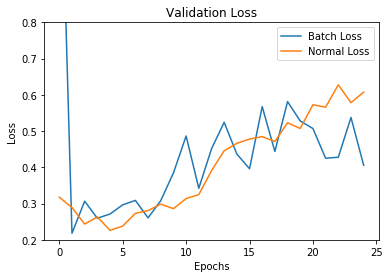

In [52]:
plt.plot(network64_256_64_batch_history.history['val_loss'])
plt.plot(network64_256_64_history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Batch Loss', 'Normal Loss'], loc = 'best')
plt.ylim(0.2, 0.8)
plt.show

We can see that despite a much worse first epoch, the version of our model with batch normalization after every convolutional and dense layer has a higher average accuracy and a lower average loss. As such, we'll continue with this architecture.

## Batch Size
We've so far been training with a batch size of 128 elements. This might not be ideal, so we'll try batch sizes of 64, 256, and 512 as well.

In [0]:
networkB64 = models.Sequential()
networkB64.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkB64.add(layers.BatchNormalization())
networkB64.add(layers.MaxPooling2D((2, 2)))
networkB64.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkB64.add(layers.BatchNormalization())
networkB64.add(layers.Flatten())
networkB64.add(layers.Dense(64, activation='relu'))
networkB64.add(layers.BatchNormalization())
networkB64.add(layers.Dense(10, activation='softmax'))
networkB64.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
networkB128 = models.Sequential()
networkB128.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkB128.add(layers.BatchNormalization())
networkB128.add(layers.MaxPooling2D((2, 2)))
networkB128.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkB128.add(layers.BatchNormalization())
networkB128.add(layers.Flatten())
networkB128.add(layers.Dense(64, activation='relu'))
networkB128.add(layers.BatchNormalization())
networkB128.add(layers.Dense(10, activation='softmax'))
networkB128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
networkB256 = models.Sequential()
networkB256.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkB256.add(layers.BatchNormalization())
networkB256.add(layers.MaxPooling2D((2, 2)))
networkB256.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkB256.add(layers.BatchNormalization())
networkB256.add(layers.Flatten())
networkB256.add(layers.Dense(64, activation='relu'))
networkB256.add(layers.BatchNormalization())
networkB256.add(layers.Dense(10, activation='softmax'))
networkB256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
networkB512 = models.Sequential()
networkB512.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkB512.add(layers.BatchNormalization())
networkB512.add(layers.MaxPooling2D((2, 2)))
networkB512.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkB512.add(layers.BatchNormalization())
networkB512.add(layers.Flatten())
networkB512.add(layers.Dense(64, activation='relu'))
networkB512.add(layers.BatchNormalization())
networkB512.add(layers.Dense(10, activation='softmax'))
networkB512.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
networkB64_history = networkB64.fit(x_train, y_train, epochs = 25, batch_size = 64, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 11s 204us/sample - loss: 0.3394 - accuracy: 0.8800 - val_loss: 0.2940 - val_accuracy: 0.8900
Epoch 2/25
54000/54000 [==============================] - 10s 184us/sample - loss: 0.2143 - accuracy: 0.9232 - val_loss: 0.3181 - val_accuracy: 0.8863
Epoch 3/25
54000/54000 [==============================] - 10s 182us/sample - loss: 0.1666 - accuracy: 0.9401 - val_loss: 0.2637 - val_accuracy: 0.9123
Epoch 4/25
54000/54000 [==============================] - 10s 184us/sample - loss: 0.1339 - accuracy: 0.9527 - val_loss: 0.2310 - val_accuracy: 0.9190
Epoch 5/25
54000/54000 [==============================] - 10s 184us/sample - loss: 0.1091 - accuracy: 0.9614 - val_loss: 0.2947 - val_accuracy: 0.9145
Epoch 6/25
54000/54000 [==============================] - 10s 183us/sample - loss: 0.0880 - accuracy: 0.9696 - val_loss: 0.4531 - val_accuracy: 0.9070
Epoch 7/25
54000/54000 [=====================

In [58]:
networkB128_history = networkB128.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 9s 159us/sample - loss: 0.3437 - accuracy: 0.8753 - val_loss: 1.4413 - val_accuracy: 0.5525
Epoch 2/25
54000/54000 [==============================] - 8s 145us/sample - loss: 0.2060 - accuracy: 0.9243 - val_loss: 0.2167 - val_accuracy: 0.9212
Epoch 3/25
54000/54000 [==============================] - 8s 145us/sample - loss: 0.1533 - accuracy: 0.9445 - val_loss: 0.2188 - val_accuracy: 0.9273
Epoch 4/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.1168 - accuracy: 0.9584 - val_loss: 0.2588 - val_accuracy: 0.9202
Epoch 5/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.0881 - accuracy: 0.9694 - val_loss: 0.2773 - val_accuracy: 0.9147
Epoch 6/25
54000/54000 [==============================] - 8s 142us/sample - loss: 0.0661 - accuracy: 0.9767 - val_loss: 0.3475 - val_accuracy: 0.9188
Epoch 7/25
54000/54000 [===========================

In [59]:
networkB256_history = networkB256.fit(x_train, y_train, epochs = 25, batch_size = 256, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 7s 136us/sample - loss: 0.3760 - accuracy: 0.8669 - val_loss: 2.3565 - val_accuracy: 0.0942
Epoch 2/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.2129 - accuracy: 0.9235 - val_loss: 1.3087 - val_accuracy: 0.6398
Epoch 3/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.1548 - accuracy: 0.9437 - val_loss: 0.4387 - val_accuracy: 0.8923
Epoch 4/25
54000/54000 [==============================] - 6s 116us/sample - loss: 0.1122 - accuracy: 0.9600 - val_loss: 0.2955 - val_accuracy: 0.8943
Epoch 5/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.0826 - accuracy: 0.9715 - val_loss: 0.2642 - val_accuracy: 0.9242
Epoch 6/25
54000/54000 [==============================] - 6s 117us/sample - loss: 0.0581 - accuracy: 0.9798 - val_loss: 0.2984 - val_accuracy: 0.9120
Epoch 7/25
54000/54000 [===========================

In [60]:
networkB512_history = networkB512.fit(x_train, y_train, epochs = 25, batch_size = 512, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 7s 125us/sample - loss: 0.4532 - accuracy: 0.8434 - val_loss: 2.2757 - val_accuracy: 0.1715
Epoch 2/25
54000/54000 [==============================] - 6s 103us/sample - loss: 0.2423 - accuracy: 0.9130 - val_loss: 2.2718 - val_accuracy: 0.1728
Epoch 3/25
54000/54000 [==============================] - 6s 104us/sample - loss: 0.1716 - accuracy: 0.9394 - val_loss: 2.2082 - val_accuracy: 0.1050
Epoch 4/25
54000/54000 [==============================] - 6s 104us/sample - loss: 0.1233 - accuracy: 0.9571 - val_loss: 1.6910 - val_accuracy: 0.4120
Epoch 5/25
54000/54000 [==============================] - 5s 101us/sample - loss: 0.0876 - accuracy: 0.9692 - val_loss: 0.8206 - val_accuracy: 0.8245
Epoch 6/25
54000/54000 [==============================] - 6s 102us/sample - loss: 0.0638 - accuracy: 0.9781 - val_loss: 0.3581 - val_accuracy: 0.8860
Epoch 7/25
54000/54000 [===========================

<function matplotlib.pyplot.show>

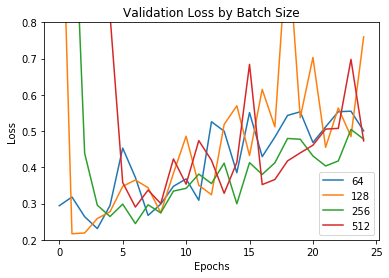

In [61]:
plt.plot(networkB64_history.history['val_loss'])
plt.plot(networkB128_history.history['val_loss'])
plt.plot(networkB256_history.history['val_loss'])
plt.plot(networkB512_history.history['val_loss'])
plt.title('Validation Loss by Batch Size')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['64', '128', '256', '512'], loc = 'best')
plt.ylim(0.2, 0.8)
plt.show

<function matplotlib.pyplot.show>

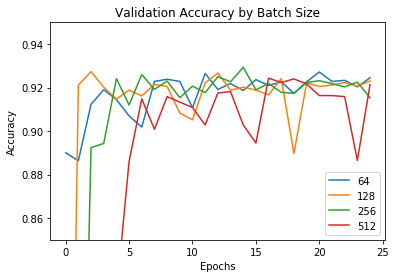

In [62]:
plt.plot(networkB64_history.history['val_accuracy'])
plt.plot(networkB128_history.history['val_accuracy'])
plt.plot(networkB256_history.history['val_accuracy'])
plt.plot(networkB512_history.history['val_accuracy'])
plt.title('Validation Accuracy by Batch Size')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['64', '128', '256', '512'], loc = 'best')
plt.ylim(0.85, 0.95)
plt.show

In [63]:
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkB64_history.history['val_loss']))
print('Minimum loss with 64 batch size:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkB128_history.history['val_loss']))
print('Minimum loss with 128 batch size:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkB256_history.history['val_loss']))
print('Minimum loss with 256 batch size:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkB512_history.history['val_loss']))
print('Minimum loss with 512 batch size:', val, 'at', idx, 'epochs')

Minimum loss with 64 batch size: 0.2309792150259018 at 3 epochs
Minimum loss with 128 batch size: 0.21672562797864278 at 1 epochs
Minimum loss with 256 batch size: 0.24476357340812682 at 6 epochs
Minimum loss with 512 batch size: 0.2903160214424133 at 6 epochs


We can see that a batch size of 128 has the lowest minimum loss of the choices, and a more consistently high average accuracy than the rest. We'll continue with this amount.

## Dropout
The next hyperparameter we'll vary is dropout. We'll vary the level of dropout between layers, from no dropout to half the neurons.

In [64]:
networkD0 = models.Sequential()
networkD0.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkD0.add(layers.BatchNormalization())
networkD0.add(layers.MaxPooling2D((2, 2)))
networkD0.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkD0.add(layers.BatchNormalization())
networkD0.add(layers.Flatten())
networkD0.add(layers.Dense(64, activation='relu'))
networkD0.add(layers.BatchNormalization())
networkD0.add(layers.Dense(10, activation='softmax'))
networkD0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkD0.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_15 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_16 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
flatten_16 (Flatten)         (None, 30976)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)              

In [65]:
networkD2 = models.Sequential()
networkD2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkD2.add(layers.BatchNormalization())
networkD2.add(layers.MaxPooling2D((2, 2)))
networkD2.add(layers.Dropout(0.2))
networkD2.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkD2.add(layers.BatchNormalization())
networkD2.add(layers.Dropout(0.2))
networkD2.add(layers.Flatten())
networkD2.add(layers.Dense(64, activation='relu'))
networkD2.add(layers.BatchNormalization())
networkD2.add(layers.Dropout(0.2))
networkD2.add(layers.Dense(10, activation='softmax'))
networkD2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkD2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_19 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 256)     

In [66]:
networkD3 = models.Sequential()
networkD3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkD3.add(layers.BatchNormalization())
networkD3.add(layers.MaxPooling2D((2, 2)))
networkD3.add(layers.Dropout(0.3))
networkD3.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkD3.add(layers.BatchNormalization())
networkD3.add(layers.Dropout(0.3))
networkD3.add(layers.Flatten())
networkD3.add(layers.Dense(64, activation='relu'))
networkD3.add(layers.BatchNormalization())
networkD3.add(layers.Dropout(0.3))
networkD3.add(layers.Dense(10, activation='softmax'))
networkD3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkD3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_22 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 256)     

In [67]:
networkD4 = models.Sequential()
networkD4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkD4.add(layers.BatchNormalization())
networkD4.add(layers.MaxPooling2D((2, 2)))
networkD4.add(layers.Dropout(0.4))
networkD4.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkD4.add(layers.BatchNormalization())
networkD4.add(layers.Dropout(0.4))
networkD4.add(layers.Flatten())
networkD4.add(layers.Dense(64, activation='relu'))
networkD4.add(layers.BatchNormalization())
networkD4.add(layers.Dropout(0.4))
networkD4.add(layers.Dense(10, activation='softmax'))
networkD4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkD4.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_25 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 11, 11, 256)     

In [68]:
networkD5 = models.Sequential()
networkD5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkD5.add(layers.BatchNormalization())
networkD5.add(layers.MaxPooling2D((2, 2)))
networkD5.add(layers.Dropout(0.5))
networkD5.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkD5.add(layers.BatchNormalization())
networkD5.add(layers.Dropout(0.5))
networkD5.add(layers.Flatten())
networkD5.add(layers.Dense(64, activation='relu'))
networkD5.add(layers.BatchNormalization())
networkD5.add(layers.Dropout(0.5))
networkD5.add(layers.Dense(10, activation='softmax'))
networkD5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkD5.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_27 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_28 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 11, 11, 256)     

In [69]:
networkD0_history = networkD0.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 9s 162us/sample - loss: 0.3511 - accuracy: 0.8754 - val_loss: 1.4679 - val_accuracy: 0.5182
Epoch 2/25
54000/54000 [==============================] - 8s 142us/sample - loss: 0.2070 - accuracy: 0.9249 - val_loss: 0.2446 - val_accuracy: 0.9095
Epoch 3/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.1548 - accuracy: 0.9449 - val_loss: 0.2342 - val_accuracy: 0.9213
Epoch 4/25
54000/54000 [==============================] - 8s 143us/sample - loss: 0.1160 - accuracy: 0.9589 - val_loss: 0.2482 - val_accuracy: 0.9173
Epoch 5/25
54000/54000 [==============================] - 8s 146us/sample - loss: 0.0873 - accuracy: 0.9694 - val_loss: 0.2594 - val_accuracy: 0.9235
Epoch 6/25
54000/54000 [==============================] - 8s 144us/sample - loss: 0.0672 - accuracy: 0.9768 - val_loss: 0.2873 - val_accuracy: 0.9263
Epoch 7/25
54000/54000 [===========================

In [70]:
networkD2_history = networkD2.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 10s 180us/sample - loss: 0.3835 - accuracy: 0.8652 - val_loss: 1.1481 - val_accuracy: 0.6665
Epoch 2/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2491 - accuracy: 0.9118 - val_loss: 0.2753 - val_accuracy: 0.8978
Epoch 3/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2072 - accuracy: 0.9259 - val_loss: 0.3318 - val_accuracy: 0.8718
Epoch 4/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.1806 - accuracy: 0.9357 - val_loss: 0.2472 - val_accuracy: 0.9105
Epoch 5/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.1597 - accuracy: 0.9423 - val_loss: 0.2060 - val_accuracy: 0.9245
Epoch 6/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.1435 - accuracy: 0.9484 - val_loss: 0.2027 - val_accuracy: 0.9290
Epoch 7/25
54000/54000 [==========================

In [71]:
networkD3_history = networkD3.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 10s 183us/sample - loss: 0.4202 - accuracy: 0.8533 - val_loss: 1.3566 - val_accuracy: 0.4748
Epoch 2/25
54000/54000 [==============================] - 9s 165us/sample - loss: 0.2782 - accuracy: 0.9011 - val_loss: 0.2604 - val_accuracy: 0.9117
Epoch 3/25
54000/54000 [==============================] - 9s 165us/sample - loss: 0.2391 - accuracy: 0.9145 - val_loss: 0.2489 - val_accuracy: 0.9112
Epoch 4/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2131 - accuracy: 0.9241 - val_loss: 0.2692 - val_accuracy: 0.9050
Epoch 5/25
54000/54000 [==============================] - 9s 166us/sample - loss: 0.1953 - accuracy: 0.9304 - val_loss: 0.2670 - val_accuracy: 0.9093
Epoch 6/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.1803 - accuracy: 0.9350 - val_loss: 0.2455 - val_accuracy: 0.9182
Epoch 7/25
54000/54000 [==========================

In [72]:
networkD4_history = networkD4.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 10s 181us/sample - loss: 0.4697 - accuracy: 0.8410 - val_loss: 1.0259 - val_accuracy: 0.6818
Epoch 2/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.3157 - accuracy: 0.8901 - val_loss: 0.2869 - val_accuracy: 0.8945
Epoch 3/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2749 - accuracy: 0.9034 - val_loss: 0.2821 - val_accuracy: 0.9018
Epoch 4/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2507 - accuracy: 0.9119 - val_loss: 0.2548 - val_accuracy: 0.9102
Epoch 5/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2321 - accuracy: 0.9170 - val_loss: 0.2254 - val_accuracy: 0.9158
Epoch 6/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2214 - accuracy: 0.9226 - val_loss: 0.2224 - val_accuracy: 0.9180
Epoch 7/25
54000/54000 [==========================

In [73]:
networkD5_history = networkD5.fit(x_train, y_train, epochs = 25, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
54000/54000 [==============================] - 10s 180us/sample - loss: 0.5110 - accuracy: 0.8264 - val_loss: 0.9756 - val_accuracy: 0.7177
Epoch 2/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.3454 - accuracy: 0.8793 - val_loss: 0.3026 - val_accuracy: 0.8953
Epoch 3/25
54000/54000 [==============================] - 9s 164us/sample - loss: 0.3101 - accuracy: 0.8921 - val_loss: 0.2629 - val_accuracy: 0.9048
Epoch 4/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2841 - accuracy: 0.8994 - val_loss: 0.2516 - val_accuracy: 0.9088
Epoch 5/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2704 - accuracy: 0.9069 - val_loss: 0.2664 - val_accuracy: 0.9078
Epoch 6/25
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2570 - accuracy: 0.9097 - val_loss: 0.2405 - val_accuracy: 0.9192
Epoch 7/25
54000/54000 [==========================

<function matplotlib.pyplot.show>

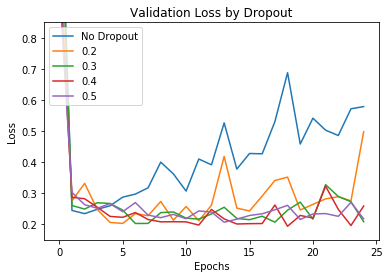

In [74]:
plt.plot(networkD0_history.history['val_loss'])
plt.plot(networkD2_history.history['val_loss'])
plt.plot(networkD3_history.history['val_loss'])
plt.plot(networkD4_history.history['val_loss'])
plt.plot(networkD5_history.history['val_loss'])
plt.title('Validation Loss by Dropout')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['No Dropout', '0.2', '0.3', '0.4', '0.5'], loc = 'upper left')
plt.ylim(0.15, 0.85)
plt.show

<function matplotlib.pyplot.show>

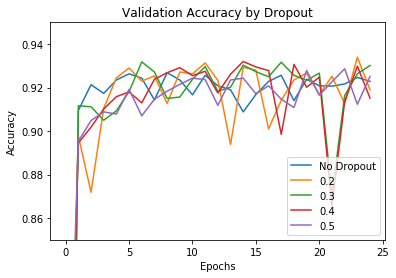

In [75]:
plt.plot(networkD0_history.history['val_accuracy'])
plt.plot(networkD2_history.history['val_accuracy'])
plt.plot(networkD3_history.history['val_accuracy'])
plt.plot(networkD4_history.history['val_accuracy'])
plt.plot(networkD5_history.history['val_accuracy'])
plt.title('Validation Accuracy by Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['No Dropout', '0.2', '0.3', '0.4', '0.5'], loc = 'lower right')
plt.ylim(0.85, 0.95)
plt.show

In [76]:
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkD0_history.history['val_loss']))
print('Minimum loss with no dropout:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkD2_history.history['val_loss']))
print('Minimum loss with 0.2 dropout:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkD3_history.history['val_loss']))
print('Minimum loss with 0.3 dropout:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkD4_history.history['val_loss']))
print('Minimum loss with 0.4 dropout:', val, 'at', idx, 'epochs')
(val, idx) = min((val, idx) for (idx, val) in enumerate(networkD5_history.history['val_loss']))
print('Minimum loss with 0.5 dropout:', val, 'at', idx, 'epochs')

Minimum loss with no dropout: 0.2341978232860565 at 2 epochs
Minimum loss with 0.2 dropout: 0.20273192328214645 at 5 epochs
Minimum loss with 0.3 dropout: 0.2024890470902125 at 6 epochs
Minimum loss with 0.4 dropout: 0.19364171493053436 at 18 epochs
Minimum loss with 0.5 dropout: 0.20658188048998516 at 13 epochs


We see that a dropout of 0.4 has both the highest accuracy and the lowest loss, so we'll use it from now on. One downside of this is that it took many more epochs for the model to reach that minimum, and it stays steady before overfitting for longer than one would like, but the advantages outweigh this.
## Weight regularization
### L2
Next we'll vary the level of L2 regularization, with values including 0, 0.01, 0.001, and 0.0001.

In [77]:
networkR0 = models.Sequential()
networkR0.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkR0.add(layers.BatchNormalization())
networkR0.add(layers.MaxPooling2D((2, 2)))
networkR0.add(layers.Dropout(0.4))
networkR0.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkR0.add(layers.BatchNormalization())
networkR0.add(layers.Dropout(0.4))
networkR0.add(layers.Flatten())
networkR0.add(layers.Dense(64, activation='relu'))
networkR0.add(layers.BatchNormalization())
networkR0.add(layers.Dropout(0.4))
networkR0.add(layers.Dense(10, activation='softmax'))
networkR0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR0.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_30 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_31 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_14 (Dropout)         (None, 11, 11, 256)     

In [78]:
networkR2 = models.Sequential()
networkR2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01), input_shape=(28, 28, 1)))
networkR2.add(layers.BatchNormalization())
networkR2.add(layers.MaxPooling2D((2, 2)))
networkR2.add(layers.Dropout(0.4))
networkR2.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
networkR2.add(layers.BatchNormalization())
networkR2.add(layers.Dropout(0.4))
networkR2.add(layers.Flatten())
networkR2.add(layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
networkR2.add(layers.BatchNormalization())
networkR2.add(layers.Dropout(0.4))
networkR2.add(layers.Dense(10, activation='softmax'))
networkR2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR2.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_33 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_34 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_17 (Dropout)         (None, 11, 11, 256)     

In [79]:
networkR3 = models.Sequential()
networkR3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001), input_shape=(28, 28, 1)))
networkR3.add(layers.BatchNormalization())
networkR3.add(layers.MaxPooling2D((2, 2)))
networkR3.add(layers.Dropout(0.4))
networkR3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)))
networkR3.add(layers.BatchNormalization())
networkR3.add(layers.Dropout(0.4))
networkR3.add(layers.Flatten())
networkR3.add(layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)))
networkR3.add(layers.BatchNormalization())
networkR3.add(layers.Dropout(0.4))
networkR3.add(layers.Dense(10, activation='softmax'))
networkR3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR3.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_36 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_37 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 11, 256)     

In [80]:
networkR4 = models.Sequential()
networkR4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.0001), input_shape=(28, 28, 1)))
networkR4.add(layers.BatchNormalization())
networkR4.add(layers.MaxPooling2D((2, 2)))
networkR4.add(layers.Dropout(0.4))
networkR4.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
networkR4.add(layers.BatchNormalization())
networkR4.add(layers.Dropout(0.4))
networkR4.add(layers.Flatten())
networkR4.add(layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.0001)))
networkR4.add(layers.BatchNormalization())
networkR4.add(layers.Dropout(0.4))
networkR4.add(layers.Dense(10, activation='softmax'))
networkR4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR4.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_39 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_40 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_23 (Dropout)         (None, 11, 11, 256)     

In [81]:
networkR0_history = networkR0.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 184us/sample - loss: 0.4628 - accuracy: 0.8408 - val_loss: 0.9263 - val_accuracy: 0.7407
Epoch 2/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.3117 - accuracy: 0.8912 - val_loss: 0.3401 - val_accuracy: 0.8783
Epoch 3/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2723 - accuracy: 0.9054 - val_loss: 0.3237 - val_accuracy: 0.8747
Epoch 4/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2469 - accuracy: 0.9124 - val_loss: 0.2269 - val_accuracy: 0.9182
Epoch 5/50
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2339 - accuracy: 0.9175 - val_loss: 0.2371 - val_accuracy: 0.9148
Epoch 6/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2187 - accuracy: 0.9223 - val_loss: 0.2228 - val_accuracy: 0.9188
Epoch 7/50
54000/54000 [==========================

In [82]:
networkR2_history = networkR2.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 186us/sample - loss: 1.3605 - accuracy: 0.8171 - val_loss: 2.4197 - val_accuracy: 0.2532
Epoch 2/50
54000/54000 [==============================] - 9s 166us/sample - loss: 0.8925 - accuracy: 0.8536 - val_loss: 0.8577 - val_accuracy: 0.8573
Epoch 3/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.8130 - accuracy: 0.8617 - val_loss: 0.7442 - val_accuracy: 0.8663
Epoch 4/50
54000/54000 [==============================] - 9s 168us/sample - loss: 0.7652 - accuracy: 0.8644 - val_loss: 0.7036 - val_accuracy: 0.8863
Epoch 5/50
54000/54000 [==============================] - 9s 166us/sample - loss: 0.7359 - accuracy: 0.8692 - val_loss: 0.6848 - val_accuracy: 0.8740
Epoch 6/50
54000/54000 [==============================] - 9s 167us/sample - loss: 0.7145 - accuracy: 0.8689 - val_loss: 0.6592 - val_accuracy: 0.8825
Epoch 7/50
54000/54000 [==========================

In [83]:
networkR3_history = networkR3.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 185us/sample - loss: 0.7696 - accuracy: 0.8382 - val_loss: 1.7838 - val_accuracy: 0.6498
Epoch 2/50
54000/54000 [==============================] - 9s 167us/sample - loss: 0.6115 - accuracy: 0.8796 - val_loss: 0.5447 - val_accuracy: 0.9003
Epoch 3/50
54000/54000 [==============================] - 9s 168us/sample - loss: 0.5700 - accuracy: 0.8876 - val_loss: 0.5492 - val_accuracy: 0.8920
Epoch 4/50
54000/54000 [==============================] - 9s 169us/sample - loss: 0.5481 - accuracy: 0.8920 - val_loss: 0.5078 - val_accuracy: 0.8988
Epoch 5/50
54000/54000 [==============================] - 9s 167us/sample - loss: 0.5325 - accuracy: 0.8930 - val_loss: 0.5304 - val_accuracy: 0.8945
Epoch 6/50
54000/54000 [==============================] - 9s 166us/sample - loss: 0.5223 - accuracy: 0.8964 - val_loss: 0.4856 - val_accuracy: 0.9075
Epoch 7/50
54000/54000 [==========================

In [84]:
networkR4_history = networkR4.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 186us/sample - loss: 0.5107 - accuracy: 0.8424 - val_loss: 1.1625 - val_accuracy: 0.7687
Epoch 2/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.4084 - accuracy: 0.8876 - val_loss: 0.3918 - val_accuracy: 0.8957
Epoch 3/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.3927 - accuracy: 0.9023 - val_loss: 0.3772 - val_accuracy: 0.9022
Epoch 4/50
54000/54000 [==============================] - 9s 166us/sample - loss: 0.3768 - accuracy: 0.9070 - val_loss: 0.3806 - val_accuracy: 0.9093
Epoch 5/50
54000/54000 [==============================] - 9s 166us/sample - loss: 0.3735 - accuracy: 0.9121 - val_loss: 0.3637 - val_accuracy: 0.9142
Epoch 6/50
54000/54000 [==============================] - 9s 166us/sample - loss: 0.3663 - accuracy: 0.9160 - val_loss: 0.3943 - val_accuracy: 0.9027
Epoch 7/50
54000/54000 [==========================

<function matplotlib.pyplot.show>

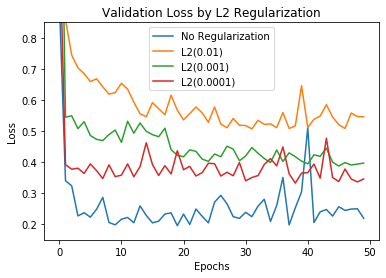

In [85]:
plt.plot(networkR0_history.history['val_loss'])
plt.plot(networkR2_history.history['val_loss'])
plt.plot(networkR3_history.history['val_loss'])
plt.plot(networkR4_history.history['val_loss'])
plt.title('Validation Loss by L2 Regularization')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['No Regularization', 'L2(0.01)', 'L2(0.001)', 'L2(0.0001)'], loc = 'best')
plt.ylim(0.15, 0.85)
plt.show

<function matplotlib.pyplot.show>

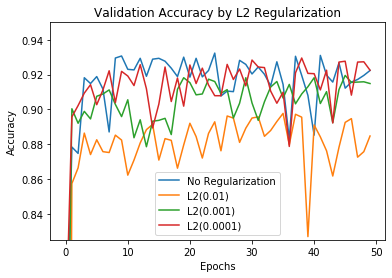

In [86]:
plt.plot(networkR0_history.history['val_accuracy'])
plt.plot(networkR2_history.history['val_accuracy'])
plt.plot(networkR3_history.history['val_accuracy'])
plt.plot(networkR4_history.history['val_accuracy'])
plt.title('Validation Accuracy by L2 Regularization')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['No Regularization', 'L2(0.01)', 'L2(0.001)', 'L2(0.0001)'], loc = 'best') 
plt.ylim(0.825, 0.95)
plt.show

We see that regularization doesn't help in any noticeable way, and in fact only increases the loss and decreases the accuracy. We will thus choose to not use L2 regularization in the later tests.
### L1
We'll try L1 regularization next, as it might act differently than the L2 regularizers we just tried. Again, we'll try values ranging from 0 to 0.01.

In [87]:
networkR22 = models.Sequential()
networkR22.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.01), input_shape=(28, 28, 1)))
networkR22.add(layers.BatchNormalization())
networkR22.add(layers.MaxPooling2D((2, 2)))
networkR22.add(layers.Dropout(0.4))
networkR22.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.01)))
networkR22.add(layers.BatchNormalization())
networkR22.add(layers.Dropout(0.4))
networkR22.add(layers.Flatten())
networkR22.add(layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.01)))
networkR22.add(layers.BatchNormalization())
networkR22.add(layers.Dropout(0.4))
networkR22.add(layers.Dense(10, activation='softmax'))
networkR22.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR22.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_42 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_43 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_26 (Dropout)         (None, 11, 11, 256)     

In [88]:
networkR23 = models.Sequential()
networkR23.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001), input_shape=(28, 28, 1)))
networkR23.add(layers.BatchNormalization())
networkR23.add(layers.MaxPooling2D((2, 2)))
networkR23.add(layers.Dropout(0.4))
networkR23.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001)))
networkR23.add(layers.BatchNormalization())
networkR23.add(layers.Dropout(0.4))
networkR23.add(layers.Flatten())
networkR23.add(layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.001)))
networkR23.add(layers.BatchNormalization())
networkR23.add(layers.Dropout(0.4))
networkR23.add(layers.Dense(10, activation='softmax'))
networkR23.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR23.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_45 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_46 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_29 (Dropout)         (None, 11, 11, 256)     

In [89]:
networkR24 = models.Sequential()
networkR24.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.0001), input_shape=(28, 28, 1)))
networkR24.add(layers.BatchNormalization())
networkR24.add(layers.MaxPooling2D((2, 2)))
networkR24.add(layers.Dropout(0.4))
networkR24.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.0001)))
networkR24.add(layers.BatchNormalization())
networkR24.add(layers.Dropout(0.4))
networkR24.add(layers.Flatten())
networkR24.add(layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1(0.0001)))
networkR24.add(layers.BatchNormalization())
networkR24.add(layers.Dropout(0.4))
networkR24.add(layers.Dense(10, activation='softmax'))
networkR24.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
networkR24.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_48 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_49 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_32 (Dropout)         (None, 11, 11, 256)     

In [90]:
networkR22_history = networkR22.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 185us/sample - loss: 15.7925 - accuracy: 0.7124 - val_loss: 13.5904 - val_accuracy: 0.1888
Epoch 2/50
54000/54000 [==============================] - 9s 167us/sample - loss: 12.0640 - accuracy: 0.7731 - val_loss: 11.9354 - val_accuracy: 0.8227
Epoch 3/50
54000/54000 [==============================] - 9s 168us/sample - loss: 11.9655 - accuracy: 0.7805 - val_loss: 11.8662 - val_accuracy: 0.7990
Epoch 4/50
54000/54000 [==============================] - 9s 167us/sample - loss: 11.9276 - accuracy: 0.7848 - val_loss: 11.9539 - val_accuracy: 0.7703
Epoch 5/50
54000/54000 [==============================] - 9s 167us/sample - loss: 11.9102 - accuracy: 0.7847 - val_loss: 11.8199 - val_accuracy: 0.7963
Epoch 6/50
54000/54000 [==============================] - 9s 167us/sample - loss: 11.8844 - accuracy: 0.7859 - val_loss: 11.7727 - val_accuracy: 0.8115
Epoch 7/50
54000/54000 [==============

In [91]:
networkR23_history = networkR23.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 184us/sample - loss: 4.1486 - accuracy: 0.7784 - val_loss: 4.3263 - val_accuracy: 0.1027
Epoch 2/50
54000/54000 [==============================] - 9s 166us/sample - loss: 2.3452 - accuracy: 0.8371 - val_loss: 2.2044 - val_accuracy: 0.8622
Epoch 3/50
54000/54000 [==============================] - 9s 166us/sample - loss: 2.1593 - accuracy: 0.8467 - val_loss: 2.0446 - val_accuracy: 0.8775
Epoch 4/50
54000/54000 [==============================] - 9s 167us/sample - loss: 2.0849 - accuracy: 0.8539 - val_loss: 2.0745 - val_accuracy: 0.8472
Epoch 5/50
54000/54000 [==============================] - 9s 167us/sample - loss: 2.0238 - accuracy: 0.8564 - val_loss: 1.9714 - val_accuracy: 0.8657
Epoch 6/50
54000/54000 [==============================] - 9s 166us/sample - loss: 1.9953 - accuracy: 0.8584 - val_loss: 1.9789 - val_accuracy: 0.8608
Epoch 7/50
54000/54000 [==========================

In [92]:
networkR24_history = networkR24.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 193us/sample - loss: 1.6468 - accuracy: 0.8292 - val_loss: 2.8123 - val_accuracy: 0.4383
Epoch 2/50
54000/54000 [==============================] - 9s 171us/sample - loss: 1.1944 - accuracy: 0.8677 - val_loss: 1.0780 - val_accuracy: 0.8952
Epoch 3/50
54000/54000 [==============================] - 9s 170us/sample - loss: 1.0667 - accuracy: 0.8776 - val_loss: 0.9651 - val_accuracy: 0.8957
Epoch 4/50
54000/54000 [==============================] - 9s 172us/sample - loss: 0.9876 - accuracy: 0.8834 - val_loss: 0.9570 - val_accuracy: 0.8775
Epoch 5/50
54000/54000 [==============================] - 9s 171us/sample - loss: 0.9298 - accuracy: 0.8868 - val_loss: 0.9687 - val_accuracy: 0.8662
Epoch 6/50
54000/54000 [==============================] - 9s 170us/sample - loss: 0.8779 - accuracy: 0.8894 - val_loss: 0.8184 - val_accuracy: 0.9010
Epoch 7/50
54000/54000 [==========================

<function matplotlib.pyplot.show>

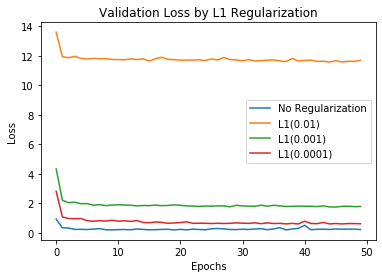

In [93]:
plt.plot(networkR0_history.history['val_loss'])
plt.plot(networkR22_history.history['val_loss'])
plt.plot(networkR23_history.history['val_loss'])
plt.plot(networkR24_history.history['val_loss'])
plt.title('Validation Loss by L1 Regularization')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['No Regularization', 'L1(0.01)', 'L1(0.001)', 'L1(0.0001)'], loc = 'best')
plt.show

<function matplotlib.pyplot.show>

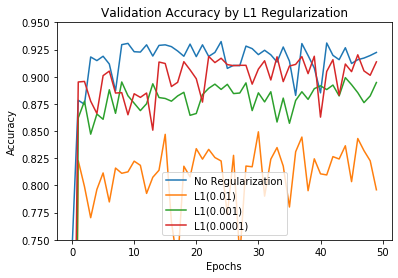

In [94]:
plt.plot(networkR0_history.history['val_accuracy'])
plt.plot(networkR22_history.history['val_accuracy'])
plt.plot(networkR23_history.history['val_accuracy'])
plt.plot(networkR24_history.history['val_accuracy'])
plt.title('Validation Accuracy by L1 Regularization')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['No Regularization', 'L1(0.01)', 'L1(0.001)', 'L1(0.0001)'], loc = 'best')
plt.ylim(0.75, 0.95)
plt.show

As before, we see that adding an L1 regularizer, whatever its magnitude, does not help the model at all. It reduces accuracy and increases loss, with no smoothing to speak of. As a result, we'll exclude all regularizers from the model.
## Learning Rate
In this test, we'll vary the learning rate. To do so, we'll create new copies of rmsprop, which we do want to keep, and only change the learning rate within them. As the default learning rate is 0.001, we'll use that along with 0.01, 0.0001, and 0.00001.

In [95]:
optimizer5 = tf.keras.optimizers.RMSprop(learning_rate = 0.00001)
optimizer4 = tf.keras.optimizers.RMSprop(learning_rate = 0.0001)
optimizer2 = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
tf.keras.optimizers.RMSprop(learning_rate = 0.0001)

In [96]:
networkL2= models.Sequential()
networkL2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkL2.add(layers.BatchNormalization())
networkL2.add(layers.MaxPooling2D((2, 2)))
networkL2.add(layers.Dropout(0.4))
networkL2.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkL2.add(layers.BatchNormalization())
networkL2.add(layers.Dropout(0.4))
networkL2.add(layers.Flatten())
networkL2.add(layers.Dense(64, activation='relu'))
networkL2.add(layers.BatchNormalization())
networkL2.add(layers.Dropout(0.4))
networkL2.add(layers.Dense(10, activation='softmax'))
networkL2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
networkL2.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_51 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_52 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_35 (Dropout)         (None, 11, 11, 256)     

In [97]:
networkL4= models.Sequential()
networkL4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkL4.add(layers.BatchNormalization())
networkL4.add(layers.MaxPooling2D((2, 2)))
networkL4.add(layers.Dropout(0.4))
networkL4.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkL4.add(layers.BatchNormalization())
networkL4.add(layers.Dropout(0.4))
networkL4.add(layers.Flatten())
networkL4.add(layers.Dense(64, activation='relu'))
networkL4.add(layers.BatchNormalization())
networkL4.add(layers.Dropout(0.4))
networkL4.add(layers.Dense(10, activation='softmax'))
networkL4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
networkL4.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_54 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_55 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_38 (Dropout)         (None, 11, 11, 256)     

In [98]:
networkL5= models.Sequential()
networkL5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
networkL5.add(layers.BatchNormalization())
networkL5.add(layers.MaxPooling2D((2, 2)))
networkL5.add(layers.Dropout(0.4))
networkL5.add(layers.Conv2D(256, (3, 3), activation='relu'))
networkL5.add(layers.BatchNormalization())
networkL5.add(layers.Dropout(0.4))
networkL5.add(layers.Flatten())
networkL5.add(layers.Dense(64, activation='relu'))
networkL5.add(layers.BatchNormalization())
networkL5.add(layers.Dropout(0.4))
networkL5.add(layers.Dense(10, activation='softmax'))
networkL5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
networkL5.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_57 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_58 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_41 (Dropout)         (None, 11, 11, 256)     

In [99]:
networkL2_history = networkL2.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 181us/sample - loss: 0.4869 - accuracy: 0.8259 - val_loss: 0.4979 - val_accuracy: 0.8335
Epoch 2/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.3280 - accuracy: 0.8836 - val_loss: 0.2996 - val_accuracy: 0.8888
Epoch 3/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.2919 - accuracy: 0.8970 - val_loss: 0.2715 - val_accuracy: 0.9043
Epoch 4/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2699 - accuracy: 0.9044 - val_loss: 0.3195 - val_accuracy: 0.8935
Epoch 5/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.2544 - accuracy: 0.9100 - val_loss: 0.3433 - val_accuracy: 0.8825
Epoch 6/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2410 - accuracy: 0.9133 - val_loss: 0.2429 - val_accuracy: 0.9140
Epoch 7/50
54000/54000 [==========================

In [100]:
networkL4_history = networkL4.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 181us/sample - loss: 0.5995 - accuracy: 0.7972 - val_loss: 1.1134 - val_accuracy: 0.5888
Epoch 2/50
54000/54000 [==============================] - 9s 165us/sample - loss: 0.4066 - accuracy: 0.8615 - val_loss: 0.3128 - val_accuracy: 0.8858
Epoch 3/50
54000/54000 [==============================] - 9s 163us/sample - loss: 0.3567 - accuracy: 0.8771 - val_loss: 0.2802 - val_accuracy: 0.8962
Epoch 4/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.3194 - accuracy: 0.8924 - val_loss: 0.2701 - val_accuracy: 0.9038
Epoch 5/50
54000/54000 [==============================] - 9s 163us/sample - loss: 0.2989 - accuracy: 0.8988 - val_loss: 0.2759 - val_accuracy: 0.8978
Epoch 6/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.2842 - accuracy: 0.9030 - val_loss: 0.2491 - val_accuracy: 0.9120
Epoch 7/50
54000/54000 [==========================

In [101]:
networkL5_history = networkL5.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 10s 181us/sample - loss: 1.0782 - accuracy: 0.6371 - val_loss: 1.1163 - val_accuracy: 0.6313
Epoch 2/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.6675 - accuracy: 0.7685 - val_loss: 0.4627 - val_accuracy: 0.8328
Epoch 3/50
54000/54000 [==============================] - 9s 163us/sample - loss: 0.5808 - accuracy: 0.8025 - val_loss: 0.4140 - val_accuracy: 0.8517
Epoch 4/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.5353 - accuracy: 0.8164 - val_loss: 0.3919 - val_accuracy: 0.8630
Epoch 5/50
54000/54000 [==============================] - 9s 164us/sample - loss: 0.5007 - accuracy: 0.8297 - val_loss: 0.3741 - val_accuracy: 0.8678
Epoch 6/50
54000/54000 [==============================] - 9s 162us/sample - loss: 0.4763 - accuracy: 0.8374 - val_loss: 0.3634 - val_accuracy: 0.8710
Epoch 7/50
54000/54000 [==========================

<function matplotlib.pyplot.show>

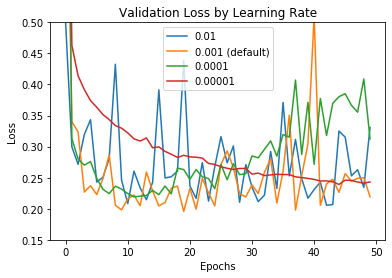

In [102]:
plt.plot(networkL2_history.history['val_loss'])
plt.plot(networkR0_history.history['val_loss'])
plt.plot(networkL4_history.history['val_loss'])
plt.plot(networkL5_history.history['val_loss'])
plt.title('Validation Loss by Learning Rate')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['0.01', '0.001 (default)', '0.0001', '0.00001'], loc = 'best')
plt.ylim(0.15, 0.5)
plt.show

<function matplotlib.pyplot.show>

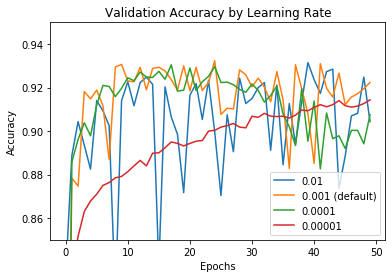

In [103]:
plt.plot(networkL2_history.history['val_accuracy'])
plt.plot(networkR0_history.history['val_accuracy'])
plt.plot(networkL4_history.history['val_accuracy'])
plt.plot(networkL5_history.history['val_accuracy'])
plt.title('Validation Accuracy by Learning Rate')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['0.01', '0.001 (default)', '0.0001', '0.00001'], loc = 'best')
plt.ylim(0.85, 0.95)
plt.show

We can see that the lowest loss and highest accuracy is still found on the model with the default learning rate. It is, however, much more jagged of a curve, and a learning rate of 0.0001 is relatively close in accuracy and loss while still smoothing out the curves and showing clear areas of underfitting and overfitting, problems which the default learning rate continued to have. As a result, we'll continue with this learning rate.
# Evaluation
The model is now complete. The hyperparameters have been adjusted to their maximum potential, so all that is left is to train the model and test it. We'll use EarlyStopping with a patience of 50, as we saw in the last trial that the model typically got worse after about 20 epochs, and this allows for some variation back upwards away from the general trend of steadily decreasing accuracy.

In [113]:
network= models.Sequential()
network.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
network.add(layers.BatchNormalization())
network.add(layers.MaxPooling2D((2, 2)))
network.add(layers.Dropout(0.4))
network.add(layers.Conv2D(256, (3, 3), activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.4))
network.add(layers.Flatten())
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.4))
network.add(layers.Dense(10, activation='softmax'))
network.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
network.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_66 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 11, 11, 256)       147712    
_________________________________________________________________
batch_normalization_67 (Batc (None, 11, 11, 256)       1024      
_________________________________________________________________
dropout_50 (Dropout)         (None, 11, 11, 256)     

In [114]:
network_history = network.fit(x_train, 
                              y_train, 
                              epochs = 200, 
                              batch_size = 128, 
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50), 
                                           tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/My Drive/AI/model.h5', monitor='val_accuracy', save_best_only=True)], 
                              validation_split = 0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/200
54000/54000 [==============================] - 10s 187us/sample - loss: 0.6069 - accuracy: 0.7974 - val_loss: 0.8914 - val_accuracy: 0.7232
Epoch 2/200
54000/54000 [==============================] - 9s 172us/sample - loss: 0.4132 - accuracy: 0.8590 - val_loss: 0.3418 - val_accuracy: 0.8730
Epoch 3/200
54000/54000 [==============================] - 9s 173us/sample - loss: 0.3592 - accuracy: 0.8775 - val_loss: 0.3025 - val_accuracy: 0.8883
Epoch 4/200
54000/54000 [==============================] - 9s 173us/sample - loss: 0.3249 - accuracy: 0.8882 - val_loss: 0.2653 - val_accuracy: 0.9035
Epoch 5/200
54000/54000 [==============================] - 9s 164us/sample - loss: 0.3013 - accuracy: 0.8974 - val_loss: 0.2614 - val_accuracy: 0.9022
Epoch 6/200
54000/54000 [==============================] - 9s 175us/sample - loss: 0.2813 - accuracy: 0.9040 - val_loss: 0.2502 - val_accuracy: 0.9097
Epoch 7/200
54000/54000 [===================

<function matplotlib.pyplot.show>

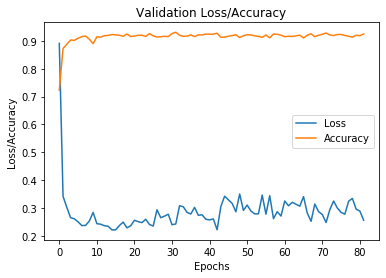

In [115]:
plt.plot(network_history.history['val_loss'])
plt.plot(network_history.history['val_accuracy'])
plt.title('Validation Loss/Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.legend(['Loss', 'Accuracy'], loc = 'best')
plt.show

As we can see, the model does begin to overfit, albeit inconsistently, after about 15 epochs. Much later, at 42 epochs, the model reaches its lowest loss and highest accuracy, and this is the version of the model that is saved. We'll now test this saved model against the Fashion_MNIST test set.

In [0]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/AI/model.h5')

In [117]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Accuracy:', test_acc)

10000/10000 [==============================] - 1s 122us/sample - loss: 0.2496 - accuracy: 0.9248
Test Accuracy: 0.9248


We can see that the model reaches a test accuracy of 92.5%. This is only ~3% better than our previous attempt with only dense layers, which achieved accuracies of ~89.1%, but it is still very good. It didn't overfit much if at all to the validation data, as it is within 0.05% of the validation accuracy at the epoch this model was saved at.

It's a good model, resolving many problems inherent to the last attempt with convolutional layers and batch normalization. It's possible that a better model could be constructed with a different combination of batch normalization and dropout, as these two layers are often at odds with each other. The model constructed here is a decent compromise between the two, and is definitely close to its theoretical peak.